In [1]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
titanic_train= pd.read_csv('/kaggle/input/titanic/train.csv', sep=',')
titanic_test= pd.read_csv('/kaggle/input/titanic/test.csv', sep=',')


titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# DATA PREPROCESSING 

The following steps is important to explore the data e make the preprocessing before apply the supervised model

# Explore the data

In [4]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# CLEAN THE NAN VALUES

In [5]:
# find the NaN values
titanic_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

i image that the Pclass and Cabin features are very related, and because the column Cabin has 687 NaN values over 891


In [6]:
# remove in primis the cabin and ticket columns

titanic_train.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [7]:
# analize the statistic of embarked column

titanic_train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [8]:
# for the embarked feature since the are only 2 nan values i replace them with the top frequency object

titanic_train['Embarked'].fillna('S', inplace=True)

# Engineering the age feature

This feature is particularly since there are 177 nan values over 891, but i don't believe that replace them with the mean, mode, median or percentile is a good idea. So i try to find the nan values with a supervised model (linear regression)


In [9]:
# in primis, since the passengers may have different age correleted with their title
# replace the name column with the title

title= ['Mr', 'Mrs', 'Miss', 'Master','Rev','Don','Major','Dr','Mme','Ms','Mlle', 'Col','Capt','Countess','Jonkheer']
range(len(title))

for item in range(len(title)):
    for index in range(len(titanic_train['Name'])):
        if title[item] in titanic_train['Name'][index]:
            titanic_train['Name'][index]= titanic_train['Name'][index].replace(titanic_train['Name'][index], title[item])
   
titanic_train['Name']   

titanic_train['Name'].unique()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


array(['Mr', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major',
       'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer'], dtype=object)

In [10]:
# map the title
mapping= {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4, 'Rev':5, 'Don':6, 'Mme':7, 'Ms':8, 'Mlle':9, 'Col':10, 'Capt':11, 'Countess':12, 'Jonkheer':13, 'Major':14, 'Dr':15}
titanic_train['Name']= titanic_train['Name'].apply(lambda x: mapping[x])

In [11]:
# rename the column
titanic_train= titanic_train.rename(columns={'Name':'Title'})

In [12]:
# i could see how many count have each title
titanic_train.groupby('Title').count()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Title,,,,,,,,,
1,647,647,647,647,511,647,647,647,647
3,180,180,180,180,144,180,180,180,180
4,40,40,40,40,36,40,40,40,40
5,6,6,6,6,6,6,6,6,6
6,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1
10,2,2,2,2,2,2,2,2,2


In [13]:
# divide the embarked and age columns (categorical features)
titanic_train= pd.get_dummies(titanic_train)
titanic_train

,PassengerId,Survived,Pclass,Title,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,22.0,1,0,7.2500,0,1,0,0,1
1,2,1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,1,3,3,26.0,0,0,7.9250,1,0,0,0,1
3,4,1,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,5,0,3,1,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,5,27.0,0,0,13.0000,0,1,0,0,1
887,888,1,1,3,19.0,0,0,30.0000,1,0,0,0,1
888,889,0,3,3,NaN,1,2,23.4500,1,0,0,0,1
889,890,1,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [14]:
titanic_train.corr()

,PassengerId,Survived,Pclass,Title,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,0.022075,0.036847,-0.057527,-0.001652,0.012658,-0.042939,0.042939,-0.001205,-0.033606,0.022204
Survived,-0.005007,1.000000,-0.338481,0.183232,-0.077221,-0.035322,0.081629,0.257307,0.543351,-0.543351,0.168240,0.003650,-0.149683
Pclass,-0.035144,-0.338481,1.000000,-0.143208,-0.369226,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.243292,0.221009,0.074053
Title,0.022075,0.183232,-0.143208,1.000000,-0.106342,0.131047,0.083095,0.082657,0.200743,-0.200743,0.021896,0.075981,-0.066997
Age,0.036847,-0.077221,-0.369226,-0.106342,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.093254,0.036261,-0.022405,-0.023233
SibSp,-0.057527,-0.035322,0.083081,0.131047,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.114631,-0.059528,-0.026354,0.068734
Parch,-0.001652,0.081629,0.018443,0.083095,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.245489,-0.011069,-0.081228,0.060814
Fare,0.012658,0.257307,-0.549500,0.082657,0.096067,0.159651,0.216225,1.000000,0.182333,-0.182333,0.269335,-0.117216,-0.162184
Sex_female,-0.042939,0.543351,-0.131900,0.200743,-0.093254,0.114631,0.245489,0.182333,1.000000,-1.000000,0.082853,0.074115,-0.119224
Sex_male,0.042939,-0.543351,0.131900,-0.200743,0.093254,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,-0.082853,-0.074115,0.119224


# Apply supervised learning mode to predict the nan values in age column

In [15]:
# make a copy of the data

df= titanic_train.copy()
df.dropna(inplace=True)  # this dataframe doesn't own the nan values
df

,PassengerId,Survived,Pclass,Title,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,22.0,1,0,7.2500,0,1,0,0,1
1,2,1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,1,3,3,26.0,0,0,7.9250,1,0,0,0,1
3,4,1,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,5,0,3,1,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,1,39.0,0,5,29.1250,1,0,0,1,0
886,887,0,2,5,27.0,0,0,13.0000,0,1,0,0,1
887,888,1,1,3,19.0,0,0,30.0000,1,0,0,0,1
889,890,1,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [16]:
# create an array with the index on nan age from titanic_train

age_nan= titanic_train.isnull().any(axis=1)
index_nan= []
for item in range(len(age_nan)):
    if age_nan[item]==True:
        index_nan.append(item)
len(index_nan)


177

In [17]:
df1= titanic_train.copy()
df1['Age'].isnull()
df_nan= df1[df1['Age'].isnull()==True]
df_nan

,PassengerId,Survived,Pclass,Title,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
5,6,0,3,1,NaN,0,0,8.4583,0,1,0,1,0
17,18,1,2,1,NaN,0,0,13.0000,0,1,0,0,1
19,20,1,3,1,NaN,0,0,7.2250,1,0,1,0,0
26,27,0,3,1,NaN,0,0,7.2250,0,1,1,0,0
28,29,1,3,3,NaN,0,0,7.8792,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,1,NaN,0,0,7.2292,0,1,1,0,0
863,864,0,3,3,NaN,8,2,69.5500,1,0,0,0,1
868,869,0,3,1,NaN,0,0,9.5000,0,1,0,0,1
878,879,0,3,1,NaN,0,0,7.8958,0,1,0,0,1


In [18]:
X_test_nan= df_nan.drop('Age', axis=1)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


# split x, y
X_ll= df.drop('Age',axis=1).values
y_ll= df['Age'].values
X_train, X_test, y_train, y_test= train_test_split(X_ll, y_ll, test_size=0.3, random_state=0)



score= []

for i in range(1,5):
    polyfeats= PolynomialFeatures(degree=i)
    X_train_poly= polyfeats.fit_transform(X_train)
    X_test_poly= polyfeats.transform(X_test)
    ll= LinearRegression()
    ll.fit(X_train_poly, y_train)
    y_pred= ll.predict(X_test_poly)
    r2= r2_score(y_test, y_pred)
    score.append(r2)
    
    print("degree "+str(i)+": R2= "+str(r2))
    



degree 1: R2= 0.33730392202754533
degree 2: R2= -65.56867941475326
degree 3: R2= -826811646984.2726
degree 4: R2= -31214273585.02251


In [20]:
# now must predict the NaN values in age column with the model prevoious created


polyfeats= PolynomialFeatures(degree=1)
X_train_poly= polyfeats.fit_transform(X_train)
X_test_poly= polyfeats.transform(X_test_nan)
ll= LinearRegression()
ll.fit(X_train_poly, y_train)
y_pred_nan= ll.predict(X_test_poly)

len(y_pred_nan)

177

In [21]:
age_not_nan= pd.Series(y_pred_nan)


for item in range(len(age_not_nan)):
    if age_not_nan[item] < 0:
        age_not_nan.replace(age_not_nan[item],1, inplace=True)
        

age_not_nan

0      32.271330
1      30.410893
2      22.144485
3      27.631843
4      25.234838
         ...    
172    28.263998
173     1.000000
174    29.488719
175    29.512061
176    22.926248
Length: 177, dtype: float64

In [22]:
titanic_train['Age'].isnull()[0]==True

False

In [23]:
# replace the NaN values in age column with the values predict by the previous model
# these values are in age_not_nan

for item in range(len(titanic_train['Age'])):
    for index in range(len(age_not_nan)):
        if titanic_train['Age'].isnull()[item] == True:
            titanic_train['Age'][item]= age_not_nan[index]



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [24]:
titanic_train['Age']

0      22.00000
1      38.00000
2      26.00000
3      35.00000
4      35.00000
         ...   
886    27.00000
887    19.00000
888    32.27133
889    26.00000
890    32.00000
Name: Age, Length: 891, dtype: float64

In [25]:
# verify that are not NaN values in dataset titanic_train

titanic_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Title          0
Age            0
SibSp          0
Parch          0
Fare           0
Sex_female     0
Sex_male       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64

# CORRELATION SURVIVED vs ALL FEATURES

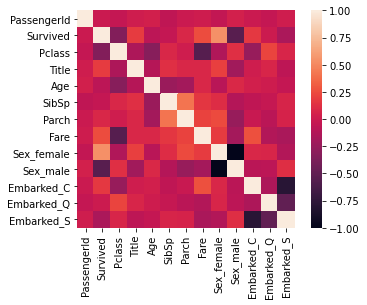

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
hm= sns.heatmap(titanic_train.corr(), cbar=True, square=True, yticklabels= titanic_train.columns, xticklabels= titanic_train.columns)
plt.show()

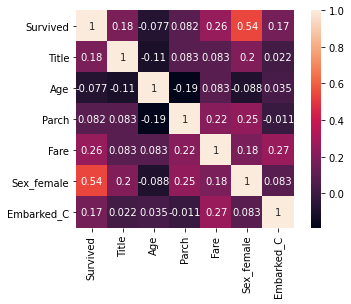

In [27]:
# the same plot but with less features and the values of corr

import seaborn as sns
cols= ["Survived","Title","Age","Parch","Fare","Sex_female","Embarked_C"]
hm= sns.heatmap(titanic_train[cols].corr(), cbar=True, square=True, yticklabels= titanic_train[cols].columns, 
                xticklabels= titanic_train[cols].columns, annot=True)
plt.show()

# SUPERVISED MODEL TARGET SURVIVED


with only the titanic_train,
the prediction on titanic_test will be later

# With the features more related

In [28]:
# SPLIT THE DATA 
from sklearn.model_selection import train_test_split

col_related= ["Title","Age","Parch","Fare","Sex_female","Embarked_C"]
X= titanic_train[col_related].values
y= titanic_train['Survived'].values

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, random_state=0)


# result of split
print("Training set has {} samples".format(X_train.shape[0]))
print("Test set has {} samples".format(X_test.shape[0]))

Training set has 623 samples
Test set has 268 samples


# Standardize features

In [29]:
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
X_train_std= scaler.fit_transform(X_train)
X_test_std= scaler.transform(X_test)


# APPLY DIFFERENT SUPERVISED MODEL

Now i use different model to evaluate the dataset, so i compare the different score


In [30]:
# import supervised learning model from sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# to star use the deafult setting for each model
# the parameters will be tune in following section
# initialize the models
clf_ada= AdaBoostClassifier(random_state=0)
clf_svc= SVC(random_state=0)
clf_knc= KNeighborsClassifier()
clf_tree= DecisionTreeClassifier(random_state=0)

In [31]:
# define a function to make a prediction
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def train_model(learner, X_train, y_train, X_test, y_test):
    
    result_acc= []
    result_fsc= []
    learner= learner.fit(X_train, y_train)
    prediction= learner.predict(X_test)
    result_acc= accuracy_score(y_test, prediction)
    result_fsc= fbeta_score(y_test, prediction,beta=0.5)
    
    print("Accuracy with {} : {}".format(learner.__class__.__name__, result_acc))
    print("F-score with {} : {}".format(learner.__class__.__name__, result_fsc))
    
    return result_acc, result_fsc


    

In [32]:
for clf in [clf_ada, clf_svc, clf_knc, clf_tree]:
    train_model(clf, X_train_std, y_train, X_test_std, y_test)


Accuracy with AdaBoostClassifier : 0.7947761194029851
F-score with AdaBoostClassifier : 0.7258064516129032
Accuracy with SVC : 0.7910447761194029
F-score with SVC : 0.7215447154471545
Accuracy with KNeighborsClassifier : 0.746268656716418
F-score with KNeighborsClassifier : 0.6644144144144145
Accuracy with DecisionTreeClassifier : 0.7611940298507462
F-score with DecisionTreeClassifier : 0.6774809160305343


# Choose the best model and model tuning

From the accuracy the best model is KNeighborsClassifier, so now i use the grid search for improve the score

In [33]:
# import grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score



clf= KNeighborsClassifier()

# create the parameters to tune in the grid search
parameters= {'n_neighbors':[2, 3, 4, 5, 6, 7, 8]}

# make the scorer with f beta
scorer= make_scorer(fbeta_score, beta=0.5)

# perform grid searc
grid= GridSearchCV(clf, parameters, scoring= scorer)

# fit the grid
grid_fit= grid.fit(X_train, y_train)


In [34]:
print("Estimator that was chosen by the search: ", grid_fit.best_estimator_)
print("Parameter setting that gave the best results on the hold out data: ", grid_fit.best_params_)

Estimator that was chosen by the search:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Parameter setting that gave the best results on the hold out data:  {'n_neighbors': 5}


In [35]:
# make prediction using optimized model
best_clf= grid_fit.best_estimator_
best_predictions= best_clf.predict(X_test_std)
accuracy_score(y_test, best_predictions)

0.373134328358209

# With all the features

In [36]:
# SPLIT THE DATA 
from sklearn.model_selection import train_test_split

X= titanic_train.drop('Survived',axis=1).values
y= titanic_train['Survived'].values

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, random_state=0)

# standard scaler
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
X_train_std= scaler.fit_transform(X_train)
X_test_std= scaler.transform(X_test)

In [37]:
# import supervised learning model from sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# to star use the deafult setting for each model
# the parameters will be tune in following section
# initialize the models
clf_ada_all= AdaBoostClassifier(random_state=0)
clf_svc_all= SVC(random_state=0)
clf_knc_all= KNeighborsClassifier()
clf_tree_all= DecisionTreeClassifier(random_state=0)

for clf in [clf_ada_all, clf_svc_all, clf_knc_all, clf_tree_all]:
    train_model(clf, X_train_std, y_train, X_test_std, y_test)

Accuracy with AdaBoostClassifier : 0.7985074626865671
F-score with AdaBoostClassifier : 0.73
Accuracy with SVC : 0.8134328358208955
F-score with SVC : 0.7563025210084033
Accuracy with KNeighborsClassifier : 0.7985074626865671
F-score with KNeighborsClassifier : 0.73
Accuracy with DecisionTreeClassifier : 0.7611940298507462
F-score with DecisionTreeClassifier : 0.6774809160305343


In this case (with all features) the model with high accuracy is SVC

In [38]:
# try to improve with grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

clf= SVC(random_state=0)

# create the parameters to tune in the grid search
parameters= {'kernel':['linear'], 'C':[0.1,0.5,1]}

# make scorer
score= make_scorer(fbeta_score, beta=0.5)

# perform grid searc
svc_search= GridSearchCV(clf, parameters, scoring=score)

# fit 
svc_search_fit= svc_search.fit(X_train, y_train)

print("Estimator that was chosen by the search: ", svc_search_fit.best_estimator_)
print("Parameter setting that gave the best results on the hold out data: ", svc_search_fit.best_params_)

Estimator that was chosen by the search:  SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)
Parameter setting that gave the best results on the hold out data:  {'C': 1, 'kernel': 'linear'}


In [39]:
# make prediction using optimized model
best_clf= svc_search_fit.best_estimator_
best_predictions= best_clf.predict(X_test_std)
print("accuracy",accuracy_score(y_test, best_predictions))

accuracy 0.7835820895522388


# SUPERVISED MODEL APPLIED TO THE TITANIC_TEST
Now make a function to clean and engineering this data, before apply the model

In [40]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [41]:
titanic_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [42]:
# the return must be the X_test to put in the model for prediction

def test_data(df):
    df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)  # remove in primis the cabin and ticket columns
    df['Fare'].fillna(df['Fare'].mean(), inplace=True) # fill the nan values in Fare feature
    
    # engineering the name column 
    for item in range(len(title)):
        for index in range(len(df['Name'])):
            if title[item] in df['Name'][index]:
                df['Name'][index]= df['Name'][index].replace(df['Name'][index], title[item])
    
    mapping= {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4, 'Rev':5, 'Don':6, 'Mme':7, 'Ms':8, 'Mlle':9, 'Col':10, 'Capt':11, 'Countess':12, 'Jonkheer':13, 'Major':14, 'Dr':15}
    df['Name']= df['Name'].apply(lambda x: mapping[x])
    df= df.rename(columns={'Name':'Title'})
    
    # divide the embarked and age columns (categorical features)
    df= pd.get_dummies(df)
    
    # engineering the age column
    df1= df.copy()
    df1.dropna(inplace=True)  # this dataframe doesn't own the nan values
    
    df2= df.copy()
    df2['Age'].isnull()
    df_nan= df2[df2['Age'].isnull()==True] # this dataframe own the age column with all nan values
    
    X_test_agenan= df_nan.drop('Age', axis=1)
    
    # split x, y
    X_ll= df1.drop('Age',axis=1).values
    y_ll= df1['Age'].values
    X_train, X_test, y_train, y_test= train_test_split(X_ll, y_ll, test_size=0.3, random_state=0)
    
    # now must predict the NaN values in age column with the model 
    polyfeats= PolynomialFeatures(degree=1)
    X_train_poly= polyfeats.fit_transform(X_train)
    X_test_poly= polyfeats.transform(X_test_agenan)
    ll= LinearRegression()
    ll.fit(X_train_poly, y_train)
    y_pred_nan= ll.predict(X_test_poly)
                
    
    return df, y_pred_nan
    
    
    
    

In [43]:
test_data(titanic_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(     PassengerId  Pclass  Title   Age  SibSp  Parch      Fare  Sex_female  \
 0            892       3      1  34.5      0      0    7.8292           0   
 1            893       3      1  47.0      1      0    7.0000           1   
 2            894       2      1  62.0      0      0    9.6875           0   
 3            895       3      1  27.0      0      0    8.6625           0   
 4            896       3      1  22.0      1      1   12.2875           1   
 ..           ...     ...    ...   ...    ...    ...       ...         ...   
 413         1305       3      1   NaN      0      0    8.0500           0   
 414         1306       1      6  39.0      0      0  108.9000           1   
 415         1307       3      1  38.5      0      0    7.2500           0   
 416         1308       3      1   NaN      0      0    8.0500           0   
 417         1309       3      4   NaN      1      1   22.3583           0   
 
      Sex_male  Embarked_C  Embarked_Q  Embarked_S  
 0       

In [44]:
age_test_nan= pd.Series(y_pred_nan)
for item in range(len(age_test_nan)):
    if age_test_nan[item] < 0:
        age_test_nan.replace(age_test_nan[item],1, inplace=True)
            
for item in range(len(titanic_test['Age'])):
    for index in range(len(age_test_nan)):
        if titanic_test['Age'].isnull()[item] == True:
            titanic_test['Age'][item]= age_test_nan[index]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [45]:
titanic_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

# APPLY SUPERVISED MODEL TO PREDICT THE SURVIVED IN TITANIC_TEST

In [46]:
titanic_test= pd.get_dummies(titanic_test)
titanic_test

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,1,34.50000,0,0,7.8292,0,1,0,1,0
1,893,3,1,47.00000,1,0,7.0000,1,0,0,0,1
2,894,2,1,62.00000,0,0,9.6875,0,1,0,1,0
3,895,3,1,27.00000,0,0,8.6625,0,1,0,0,1
4,896,3,1,22.00000,1,1,12.2875,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,32.27133,0,0,8.0500,0,1,0,0,1
414,1306,1,6,39.00000,0,0,108.9000,1,0,1,0,0
415,1307,3,1,38.50000,0,0,7.2500,0,1,0,0,1
416,1308,3,1,32.27133,0,0,8.0500,0,1,0,0,1


In [47]:
# standard scaler
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
X_final_test= scaler.fit_transform(titanic_test)

In [48]:
clf_svc_all

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [49]:
Survived= clf_svc_all.predict(X_final_test)
Survived

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [50]:
Survived= pd.DataFrame(Survived)
Survived

,0
0,0
1,0
2,0
3,0
4,0
...,...
413,0
414,1
415,0
416,0


In [51]:
titanic= titanic_test.join(Survived)
titanic= titanic.rename(columns={0:'Survived'})
titanic.head()


,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
0,892,3,1,34.5,0,0,7.8292,0,1,0,1,0,0
1,893,3,1,47.0,1,0,7.0000,1,0,0,0,1,0
2,894,2,1,62.0,0,0,9.6875,0,1,0,1,0,0
3,895,3,1,27.0,0,0,8.6625,0,1,0,0,1,0
4,896,3,1,22.0,1,1,12.2875,1,0,0,0,1,0


In [52]:
titanic_pred_final= titanic[['PassengerId','Survived']]
titanic_pred_final.values

array([[ 892,    0],
       [ 893,    0],
       [ 894,    0],
       [ 895,    0],
       [ 896,    0],
       [ 897,    0],
       [ 898,    1],
       [ 899,    0],
       [ 900,    1],
       [ 901,    0],
       [ 902,    0],
       [ 903,    0],
       [ 904,    1],
       [ 905,    0],
       [ 906,    1],
       [ 907,    1],
       [ 908,    0],
       [ 909,    0],
       [ 910,    0],
       [ 911,    1],
       [ 912,    0],
       [ 913,    1],
       [ 914,    1],
       [ 915,    0],
       [ 916,    1],
       [ 917,    0],
       [ 918,    1],
       [ 919,    0],
       [ 920,    0],
       [ 921,    0],
       [ 922,    0],
       [ 923,    0],
       [ 924,    0],
       [ 925,    0],
       [ 926,    0],
       [ 927,    0],
       [ 928,    1],
       [ 929,    1],
       [ 930,    0],
       [ 931,    0],
       [ 932,    0],
       [ 933,    0],
       [ 934,    0],
       [ 935,    1],
       [ 936,    1],
       [ 937,    0],
       [ 938,    0],
       [ 939,

In [53]:
titanic_pred_final.to_csv('titanic_pred_final.csv' , index=False)